In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyproj import Transformer, CRS, Proj
from geoviews import opts
from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform
from cartopy import crs
import holoviews as hv
import mapclassify as mc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import clear_output, display, HTML, Markdown
import shapely.speedups as speedups
speedups.enable()

/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
OUTPUT = Path.cwd().parents[0] / "Output"

df = pd.read_csv(Path.cwd().parents[0]/ "CSV" / "HLL" /"latlng_to_geohash.csv")

gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df.longitude_3, df.latitude_3),
                      crs = "EPSG:4326"
                      )

gdf.head()

,latitude_3,longitude_3,usercount,postcount,hashtags,geometry
0,51.328125,-0.703125,1225,2219,muslimban,POINT (-0.70312 51.32812)
1,51.328125,-0.703125,1129,2135,refugees,POINT (-0.70312 51.32812)
2,51.328125,-0.703125,953,1974,refugeeswelcome,POINT (-0.70312 51.32812)
3,48.515625,2.109375,917,2831,migrants,POINT (2.10938 48.51562)
4,51.328125,-0.703125,883,1704,immigration,POINT (-0.70312 51.32812)


In [3]:
GRID_SIZE_METERS = 250000 
                        
# target projection: Web Mercator (epsg code)
EPSG_CODE = 3857
# note: Mollweide defined by _esri_
# in epsg.io's database
CRS_PROJ = f"epsg:{EPSG_CODE}"
# Input projection WGS 84
CRS_WGS = "epsg:4326"

# define Transformer ahead of time
# with xy-order of coordinates
PROJ_TRANSFORMER = Transformer.from_crs(
    CRS_WGS, CRS_PROJ, always_xy=True)

# also define reverse projection
PROJ_TRANSFORMER_BACK = Transformer.from_crs(
    CRS_PROJ, CRS_WGS, always_xy=True)

In [4]:
XMIN = PROJ_TRANSFORMER.transform(-18.984375, 27.421875)[0]
XMAX = PROJ_TRANSFORMER.transform(35.859375, 27.421875)[0]
YMAX = PROJ_TRANSFORMER.transform(49.21875, 71.015625)[1]
YMIN = PROJ_TRANSFORMER.transform(49.21875, 27.421875)[1]

In [5]:
print(f'Projected bounds: {[XMIN, YMIN, XMAX, YMAX]}')

Projected bounds: [-2113330.9580285526, 3176279.0534006394, 3991847.365165044, 11407616.83504398]


In [7]:
width = GRID_SIZE_METERS
length = GRID_SIZE_METERS
cols = list(range(int(np.floor(XMIN)), int(np.ceil(XMAX)), width))
rows = list(range(int(np.floor(YMIN)), int(np.ceil(YMAX)), length))


polygons = []
for x in cols:
     for y in rows:
            # combine to tuple: (x,y, poly)
            # and append to list
            polygons.append(
                (x, y,
                 Polygon([
                     (x, y),
                     (x+width, y),
                     (x+width, y-length),
                     (x, y-length)])))
grid = pd.DataFrame(polygons)
    # name columns
col_labels=['xbin', 'ybin', 'bin_poly']
grid.columns = col_labels
    # use x and y as index columns
grid.set_index(['xbin', 'ybin'], inplace=True)
grid.head()

In [8]:
grid = gpd.GeoDataFrame(
        grid.drop(
            columns=["bin_poly"]),
            geometry=grid.bin_poly)
grid.crs = CRS_PROJ

In [9]:
eu = gpd.read_file(Path.cwd().parents[0]/ "Europe_coastline_shapefile" / "eu_shp_4326.shp",crs =CRS_WGS)
eu = eu.to_crs(CRS_PROJ)

CPU times: user 988 ms, sys: 375 ms, total: 1.36 s
Wall time: 883 ms


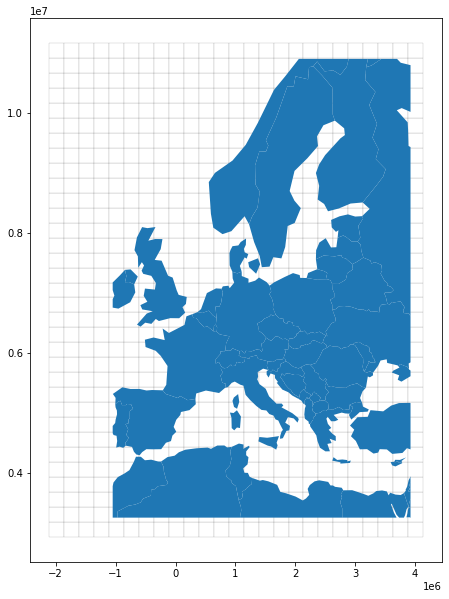

In [10]:
%%time

base = grid.plot(figsize=(15,10), color='white', edgecolor='black', linewidth=0.1)
# combine with world geometry
plot = eu.plot(ax=base)

In [11]:
grid_join = gpd.sjoin(gdf.to_crs(epsg=3857),grid, how="left", op='within')
grid_join.head()

,latitude_3,longitude_3,usercount,postcount,hashtags,geometry,index_right0,index_right1
0,51.328125,-0.703125,1225,2219,muslimban,POINT (-78271.517 6679541.766),-113331.0,6926279.0
1,51.328125,-0.703125,1129,2135,refugees,POINT (-78271.517 6679541.766),-113331.0,6926279.0
2,51.328125,-0.703125,953,1974,refugeeswelcome,POINT (-78271.517 6679541.766),-113331.0,6926279.0
3,48.515625,2.109375,917,2831,migrants,POINT (234814.551 6193069.198),136669.0,6426279.0
4,51.328125,-0.703125,883,1704,immigration,POINT (-78271.517 6679541.766),-113331.0,6926279.0


In [12]:
grid_join.rename(columns={'index_right0': 'xbin','index_right1':'ybin'},inplace = True)
grid_join.drop(columns =["latitude_3","longitude_3"],inplace =True)
grid_join["xbin"].isna().sum()

3

In [13]:
grid_join=grid_join.dropna()
grid_join["ybin"].isna().sum()

0

In [14]:
grid_join = grid_join.drop(columns = ['geometry'])

In [15]:
grid_join

,usercount,postcount,hashtags,xbin,ybin
0,1225,2219,muslimban,-113331.0,6926279.0
1,1129,2135,refugees,-113331.0,6926279.0
2,953,1974,refugeeswelcome,-113331.0,6926279.0
3,917,2831,migrants,136669.0,6426279.0
4,883,1704,immigration,-113331.0,6926279.0
...,...,...,...,...,...
143243,1,1,essereumani,1636669.0,5176279.0
143244,1,1,facciadiculo,1636669.0,5176279.0
143245,1,1,facebook,1636669.0,5176279.0
143246,1,1,falsita,1636669.0,5176279.0


In [16]:
%%time
grid_map = grid_join.merge(grid, on='xbin')
grid_map

CPU times: user 766 ms, sys: 224 ms, total: 990 ms
Wall time: 990 ms


,usercount,postcount,hashtags,xbin,ybin,geometry
0,1225,2219,muslimban,-113331.0,6926279.0,"POLYGON ((-113331.000 3176279.000, 136669.000 ..."
1,1225,2219,muslimban,-113331.0,6926279.0,"POLYGON ((-113331.000 3426279.000, 136669.000 ..."
2,1225,2219,muslimban,-113331.0,6926279.0,"POLYGON ((-113331.000 3676279.000, 136669.000 ..."
3,1225,2219,muslimban,-113331.0,6926279.0,"POLYGON ((-113331.000 3926279.000, 136669.000 ..."
4,1225,2219,muslimban,-113331.0,6926279.0,"POLYGON ((-113331.000 4176279.000, 136669.000 ..."
...,...,...,...,...,...,...
4727047,1,1,immigration,3636669.0,4926279.0,"POLYGON ((3636669.000 10176279.000, 3886669.00..."
4727048,1,1,immigration,3636669.0,4926279.0,"POLYGON ((3636669.000 10426279.000, 3886669.00..."
4727049,1,1,immigration,3636669.0,4926279.0,"POLYGON ((3636669.000 10676279.000, 3886669.00..."
4727050,1,1,immigration,3636669.0,4926279.0,"POLYGON ((3636669.000 10926279.000, 3886669.00..."


In [17]:
grid_map.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
!pip install pyarrow

     |████████████████████████████████| 21.9 MB 100 kB/s eta 0:00:01     |██████████████████              | 12.3 MB 9.2 MB/s eta 0:00:02     |█████████████████████████▍      | 17.3 MB 4.8 MB/s eta 0:00:01     |██████████████████████████████▉ | 21.1 MB 4.8 MB/s eta 0:00:01


In [20]:
%%time
grid_map.to_feather(OUTPUT /'geohash_hll.feather') 

<timed eval>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')


CPU times: user 43.7 s, sys: 1.45 s, total: 45.1 s
Wall time: 49.7 s
